# Clustering time series

## Data

In [ ]:
path = 'Sales_Transactions_Dataset_Weekly (1).csv'
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

X = pd.read_csv(path)
X.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [ ]:
X['Mean'] = X.iloc[:, 1:53].mean(axis=1)
X_centered = X.iloc[:,  1:53].sub(X['Mean'], axis=0)

X_centered.shape
X_centered.head()
#X_centered.mean(axis=1)

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,1.365385,2.365385,0.365385,-1.634615,3.365385,2.365385,4.365385,11.365385,-3.634615,4.365385,...,-5.634615,-2.634615,-1.634615,0.365385,2.365385,-6.634615,-2.634615,-3.634615,-4.634615,0.365385
1,3.019231,2.019231,-0.980769,-1.980769,3.019231,-2.980769,2.019231,-0.980769,-0.980769,-0.980769,...,-1.980769,0.019231,1.019231,-2.980769,-2.980769,0.019231,1.019231,-2.980769,2.019231,-3.980769
2,-1.692308,2.307692,-0.692308,0.307692,1.307692,-0.692308,-1.692308,4.307692,3.307692,-2.692308,...,-2.692308,5.307692,-3.692308,-3.692308,-1.692308,-0.692308,5.307692,-0.692308,-0.692308,-1.692308
3,3.730769,-0.269231,4.730769,-3.269231,0.730769,-2.269231,0.730769,4.730769,4.730769,2.730769,...,0.730769,1.730769,-5.269231,-4.269231,-2.269231,-0.269231,5.730769,-0.269231,-1.269231,-0.269231
4,-0.461538,-3.461538,4.538462,2.538462,-2.461538,-1.461538,0.538462,5.538462,0.538462,0.538462,...,-1.461538,2.538462,-1.461538,3.538462,-2.461538,-2.461538,-3.461538,2.538462,-0.461538,0.538462


In [ ]:
np.all(np.isclose(X_centered.mean(axis=1), 0)) # Check if all the mean are 0

True

## Task 1: Fitting NCS

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import splev, interp1d
from sklearn.linear_model import LinearRegression

In [ ]:
# converted from R's ns()
# ns function
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oright, :] = xr @ tt

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis


In [ ]:
# Create F(design matrix)
# def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):

time_points = np.arange(1, 53) # time_points: week 1- week52
F = ns(time_points, df=9, include_intercept=False) # knots, boundary_knots are calculated in the ns() when df is given

# Remove the column mean -> meaning no intercept
F_centered = F - np.mean(F, axis=0)
F_centered.shape
#F_centered.mean(axis=0)

(52, 9)

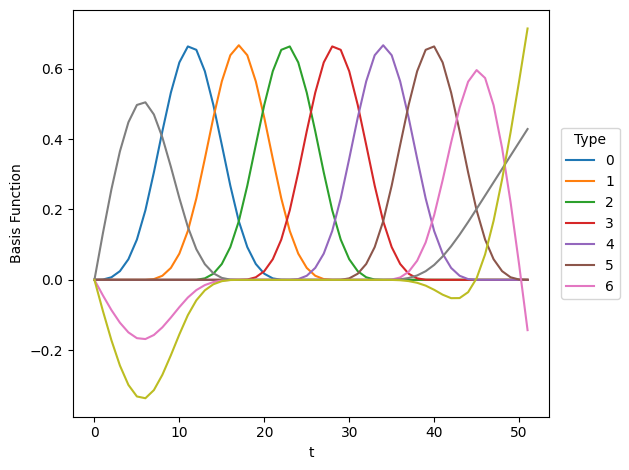

In [ ]:
plt.plot(F)
plt.xlabel("t")
plt.ylabel("Basis Function")
plt.legend(range(7), title="Type",
           bbox_to_anchor=(1.01, 0.5), loc="center left")
plt.tight_layout()

In [ ]:
np.isclose(F_centered.mean(axis=0), 0) # Check if all the mean are 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
# Get B transpose Bt=(Ft*F)^−1 * Ft*Xt.
B_transpose = np.linalg.inv(F_centered.T @ F_centered) @ F_centered.T @ X_centered.T
B = B_transpose.T  # 811x9 matrix of coefficients
B.head()

,0,1,2,3,4,5,6,7,8
0,3.642672,-2.732720,-1.319207,-2.468299,-0.682322,1.997203,-5.426055,-0.509776,-4.167850
1,-4.630675,1.248344,-0.997914,-1.449703,-1.801333,-1.060794,-2.545953,-4.562277,-1.892383
2,0.576199,0.093009,2.995650,-0.752826,1.791642,-1.208942,-0.751702,2.520911,-0.897869
3,-2.513186,-0.207281,-0.406175,-5.960619,0.478160,-0.823106,-3.902554,-1.371696,-0.613252
4,3.412425,1.492129,2.790321,-0.727958,-3.384495,0.131409,-0.619072,2.045970,-0.465328


## Task 2: Cluster Matrix B

In [ ]:
from sklearn.cluster import KMeans

# Run Kmeans on B(The coef)
# Note:
# When using matrix B for clustering, the centers are the average of the rows of B within each cluster. To get the corresponding time series from a cluster center b, use the matrix product Fb
# fit(B) -> for each cluster, center == mean(rows in the cluster)

kmeans = KMeans(n_clusters=6, random_state=7216)
clusters = kmeans.fit_predict(B)
cluster_centers = kmeans.cluster_centers_ # b(centers of each clusters): 9 points and 6 items(clusters)
cluster_centers

array([[-3.20296165e+00,  1.11838762e+01, -3.57046830e+00,
        -6.91349219e+00, -3.67088886e+00, -1.31536980e+00,
        -3.12040106e+00,  1.30846662e+00, -1.21062455e+01],
       [ 4.16122048e-01,  3.50254164e-01,  1.02406991e+00,
        -3.78228360e-01,  4.99053257e-02,  2.01060965e-01,
        -1.62279228e-01,  1.30926526e+00,  9.24961026e-01],
       [ 7.63342306e-01, -3.17018843e+00,  8.14412941e-01,
        -6.53041150e+00, -3.59612453e+00, -3.79459961e+00,
        -3.89081759e+00, -6.03921676e+00, -2.18788113e-01],
       [ 5.86164047e+00,  9.83574237e+00,  4.73168431e+00,
        -7.09795570e+00,  5.83269501e+00, -5.10600374e+00,
         5.87034629e+00,  7.72933048e+00, -1.22246268e+01],
       [ 3.82289493e+00, -2.41132543e-01,  1.42634999e+01,
        -6.88213411e+00,  5.23448190e-03,  3.30658791e-01,
        -4.99627504e-01,  7.73648691e+00,  8.48967105e+00],
       [ 6.12548527e-01, -6.23073789e-01, -3.52343700e+00,
        -1.62045043e+01, -1.82505977e+00, -1.270468

In [ ]:
# Calculate cluster center time series using F(cetered version) and cluster centers of B
# corresponding time series from a cluster center b, F_centered*b
cluster_time_series = F_centered @ cluster_centers.T
cluster_time_series.shape #52weeks for 6clusters

(52, 6)

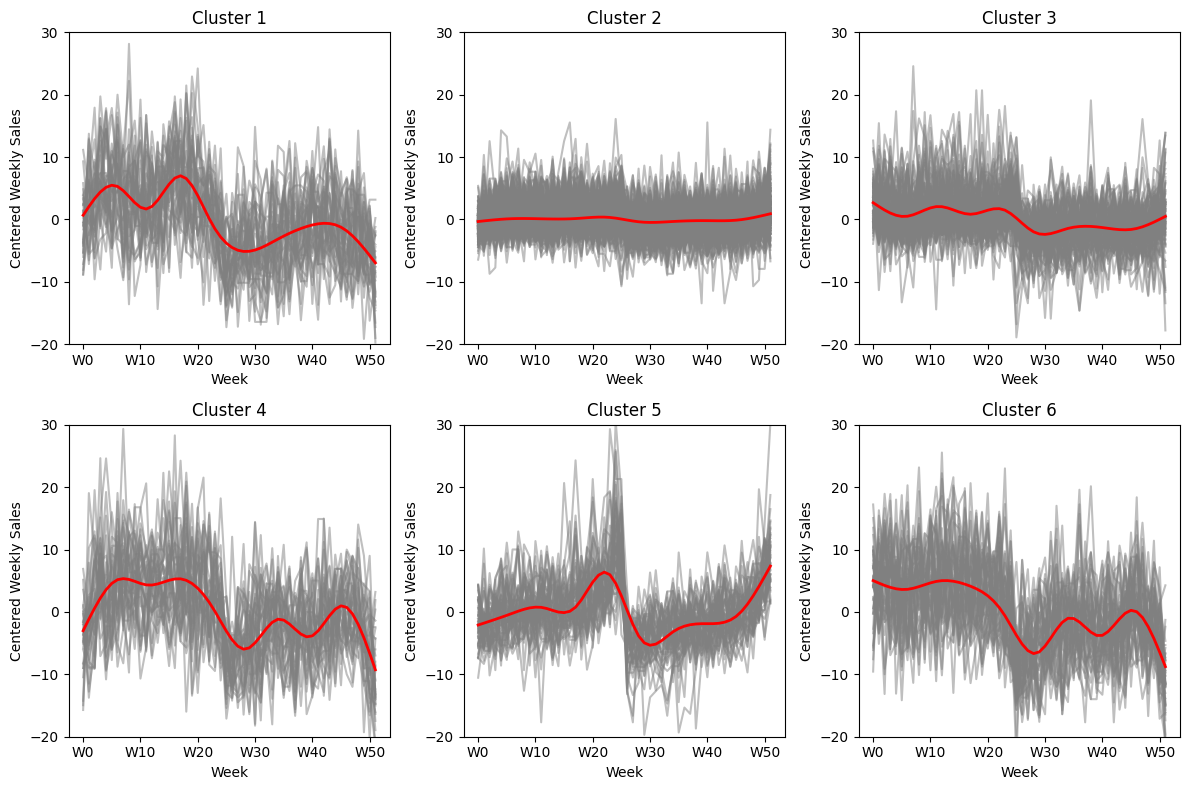

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    cluster_indices = np.where(clusters == i)[0]

    for idx in cluster_indices:
        axes[i].plot(X_centered.iloc[idx], color='grey', alpha=0.5)

    axes[i].plot(cluster_time_series[:, i], color='red', linewidth=2)

    axes[i].set_title(f"Cluster {i + 1}")
    axes[i].set_xlabel("Week")
    axes[i].set_ylabel("Centered Weekly Sales")
    axes[i].set_xticks([0, 10, 20, 30, 40, 50])
    axes[i].set_ylim(-20, 30)


plt.tight_layout()
plt.show()

## Task 3: Cluster Matrix X

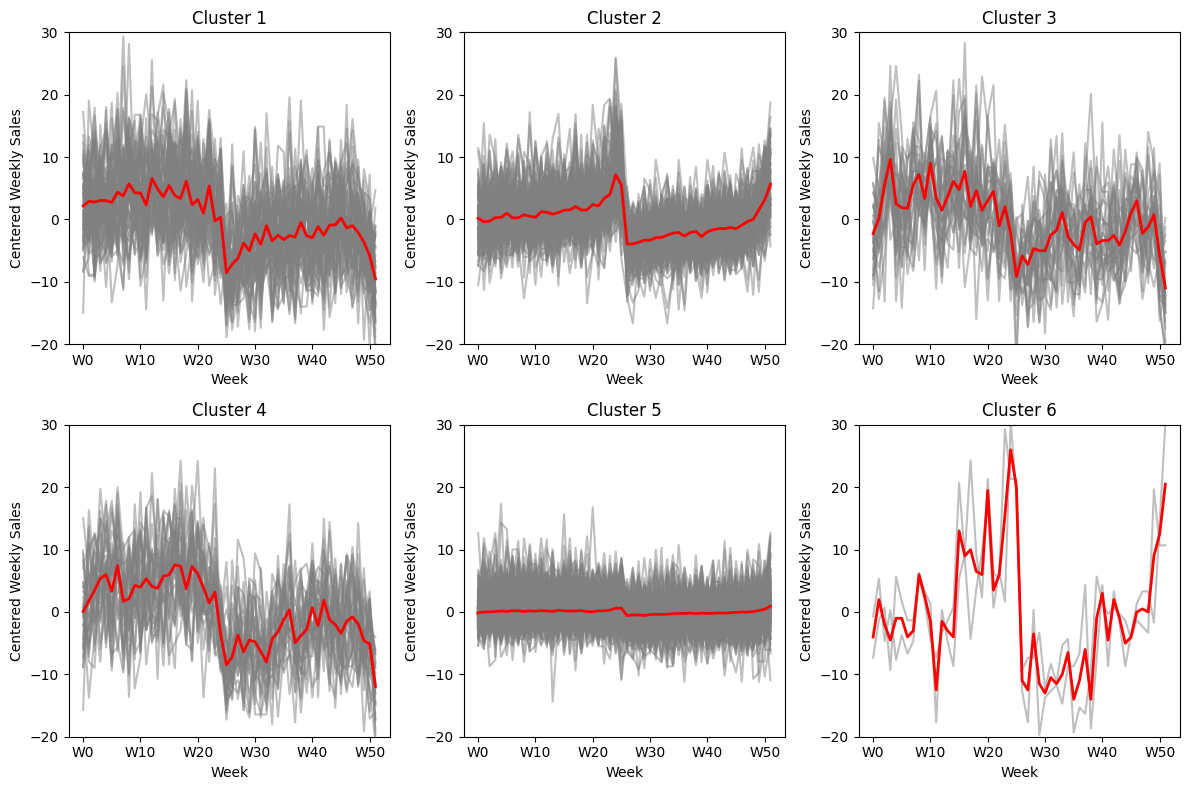

In [ ]:
# Kmeans for X_centered
kmeans_X = KMeans(n_clusters=6, random_state=7216)
clusters_X = kmeans_X.fit_predict(X_centered)
cluster_centers_X = kmeans_X.cluster_centers_  # cluster centers for X

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    cluster_indices = np.where(clusters_X == i)[0]

    for idx in cluster_indices:
        axes[i].plot(X_centered.iloc[idx], color='grey', alpha=0.5)

    axes[i].plot(cluster_centers_X[i], color='red', linewidth=2)

    axes[i].set_title(f"Cluster {i + 1}")
    axes[i].set_xlabel("Week")
    axes[i].set_ylabel("Centered Weekly Sales")
    axes[i].set_xticks([0, 10, 20, 30, 40, 50])
    axes[i].set_ylim(-20, 30)

plt.tight_layout()
plt.show()

The cluster center lines of Task 2 are smoother than Task 3 because the making the spline(ns) reduces noise and makes line for general trends compared to using the raw time series X_centered like Task 3.